# Проект "Классификация комментариев"

### Источник данных
Набор данных с разметкой о токсичности правок.

### Основные цели проекта 
Для запуска нового сервиса интернет-магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. 

- Необходимо обучить модель классифицировать комментарии на позитивные и негативные. 
- Построить модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
#Импорт необходимых библиотек.
import pandas as pd
import numpy as np
import time
import warnings
from pymystem3 import Mystem
import re
import nltk
import torch
import transformers
import lightgbm as lgb
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#Загружаем данные и смотрим на них.
#data = pd.read_csv('toxic_comments.csv')

try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
#Смотрим общую информацию.
print(data.info())

#Определяю количество пропущенных значений в столбцах data.
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None
text     0
toxic    0
dtype: int64


In [4]:
#Выводим список уникальных значений для столбца toxic.
print('Столбец toxic:', data['toxic'].unique())

Столбец toxic: [0 1]


**Вывод**

- Нет пропусков в данных.
- Нет выбросов в столбце toxic.

In [5]:
#Добавим столбец, с очищенными от лишних пробелов и символов строками, оставив в них только слова и пробелы.
lemm_text = []
#m = Mystem()
nltk.download('wordnet')
m = WordNetLemmatizer()

#Переведём тексты в стандартный для Python формат: кодировку Unicode (U) и пройдем по ним циклом:
#1.почистим текст, оставив в тексте только буквенные символы и пробелы,
#2.лемматизируем данные.
for text in data['text'].values.astype('U'):
    clean_text = re.sub(r'[^a-zA-Z]',' ',text)
    lemm_list = m.lemmatize(" ".join(clean_text.split()))
    lemm_text.append("".join(lemm_list))

#Добавим столбец в исходный датасет.    
data['lemm_text'] = lemm_text

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
data['lemm_text']

0         Explanation Why the edits made under my userna...
1         D aww He matches this background colour I m se...
2         Hey man I m really not trying to edit war It s...
3         More I can t make any real suggestions on impr...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159566    And for the second time of asking when your vi...
159567    You should be ashamed of yourself That is a ho...
159568    Spitzer Umm theres no actual article for prost...
159569    And it looks like it was actually you who put ...
159570    And I really don t think you understand I came...
Name: lemm_text, Length: 159571, dtype: object

In [7]:
#Создаем мешки слов с учётом стоп-слов.
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

#tf_idf = count_tf_idf.fit_transform(data['lemm_text'].values) 
#Сделаем настройки после разделения выборки.

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение

In [8]:
#Разобъем данные на 2 выборки: обучающую и тестовую в соотношении: 90/10.
data_train, data_test = train_test_split(data, test_size=0.2, random_state=12345)
#tf_idf_train, tf_idf_test = train_test_split(tf_idf, test_size=0.2, random_state=12345)

In [9]:
tf_idf_train = count_tf_idf.fit_transform(data_train['lemm_text'].values) 
tf_idf_test = count_tf_idf.transform(data_test['lemm_text'].values)

In [10]:
#Для анализа зафиксируем признаки в переменных features_, а целевой признак в target_ для каждой из 2-ух выборок.
features_train = tf_idf_train
target_train = data_train['toxic'].values

#Тестовая выборка.
features_test = tf_idf_test
target_test = data_test['toxic'].values

<font color=purple>Изучим дисбаланс классов.</font>

In [11]:
#Посмотрим на доли классов.
data['toxic'].value_counts(normalize = True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

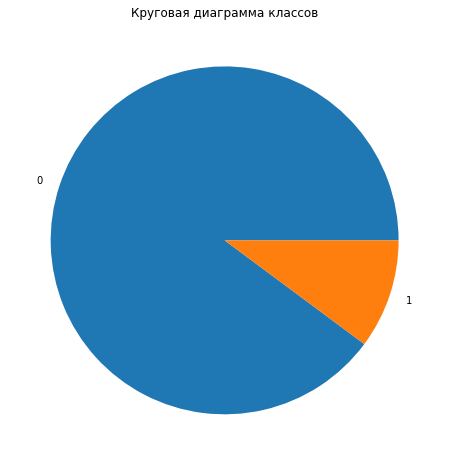

In [12]:
#Визаулизируем доли.
data_pie = data.groupby('toxic').size()

data_pie.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Круговая диаграмма классов")
plt.ylabel("")
plt.show()

**Вывод**
По проведенному исследованию видно, что в данных есть дисбаланс классов:

- 0: 0.898321
- 1: 0.101679

<font color=purple>Обучим модель LogisticRegression.</font>

In [13]:
#Обучим модель LogisticRegression.
#Не будем бороться с дисбалансом классов сейчас.
start_time = time.time()
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

model_lr = LogisticRegression(penalty='l2', C=3.0, random_state=12345)
model_lr.fit(features_train, target_train)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Затраченное время (сек) = 11.555831670761108


In [14]:
#Расчитаем F1 для модели.
start_time = time.time()
predicted_lr = model_lr.predict(features_test)
f1_lr = f1_score(target_test, predicted_lr)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)
print('F1-мера:', f1_lr)

Затраченное время (сек) = 0.03471517562866211
F1-мера: 0.7617347849366412


**Обучим логистическую регрессию, сделав веса классов сбалансированными. Придадим объектам редкого класса больший вес.**

In [15]:
#Обучим модель LogisticRegression.
#Обучим логистическую регрессию, сделав веса классов сбалансированными. 
#Придадим объектам редкого класса больший вес.
start_time = time.time()
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

model_lr = LogisticRegression(penalty='l2', C=3.0, random_state=12345, solver='liblinear', class_weight='balanced')
model_lr.fit(features_train, target_train)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)

Затраченное время (сек) = 17.050134658813477


In [16]:
#Расчитаем F1 для модели.
start_time = time.time()
predicted_lr = model_lr.predict(features_test)
f1_lr = f1_score(target_test, predicted_lr)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)
print('F1-мера:', f1_lr)

Затраченное время (сек) = 0.023708820343017578
F1-мера: 0.7649937089333148


**Вывод**

- Точность увеличилась: F1-мера выросла с 0.76 до 0.77.
- Скорость обучения выросла в 2 раза.
- Скорость расчета прогноза выросла в 1,2 раза.

<font color=purple>Обучим модель градиентного бустинга LightGBM.</font>

In [17]:
#Обучим модель градиентного бустинга LightGBM.
#Не будем бороться с дисбалансом классов сейчас.
start_time = time.time()
warnings.filterwarnings("ignore", category=DataConversionWarning)

model_lgb = LGBMClassifier(learning_rate=0.1, max_depth=6, n_estimators=700, n_jobs=-1, num_leaves=900) 
model_lgb.fit(features_train, target_train)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)

Затраченное время (сек) = 1245.8847920894623


In [18]:
#Расчитаем F1 для модели.
start_time = time.time()
predicted_lgb = model_lgb.predict(features_test)
f1_lgb = f1_score(target_test, predicted_lgb)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)
print('F1-мера:', f1_lgb)

Затраченное время (сек) = 10.178069353103638
F1-мера: 0.7528735632183908


**Обучим модель градиентного бустинга LightGBM, сделав веса классов сбалансированными. Придадим объектам редкого класса больший вес.**

In [19]:
#Обучим модель градиентного бустинга LightGBM, сделав веса классов сбалансированными. 
#Придадим объектам редкого класса больший вес.
start_time = time.time()
warnings.filterwarnings("ignore", category=DataConversionWarning)

model_lgb = LGBMClassifier(learning_rate=0.1, max_depth=6, n_estimators=700, 
                           n_jobs=-1, num_leaves=900, class_weight='balanced') 
model_lgb.fit(features_train, target_train)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)

Затраченное время (сек) = 1211.5259873867035


In [20]:
#Расчитаем F1 для модели.
start_time = time.time()
predicted_lgb = model_lgb.predict(features_test)
f1_lgb = f1_score(target_test, predicted_lgb)
cut_time = time.time()
print("Затраченное время (сек) =", cut_time - start_time)
print('F1-мера:', f1_lgb)

Затраченное время (сек) = 10.275203227996826
F1-мера: 0.7458793177583488


**Вывод**

- Точность уменьшилась: F1-мера с 0.753 до 0.745.
- Скорость обучения стала ниже в 1,01 раза.
- Скорость расчета прогноза стала ниже в 0,98 раза.

**Итоги после борьбы с дисбалансом классов.**

Значения метрики F1, полученные на разных моделях:
- LogisticRegression: 0.7649937089333148
- LightGBM: 0.7451036866359446

Результат LightGBM стал неудовлетворяющим условиям. До борьбы с дисбалансом результат удовлетворял: 0.7531019600791224.

## Выводы

В качестве инструмента, который будет искать токсичные комментарии и отправлять их на модерацию, предлагаем использовать модель LogisticRegression после борьбы с дисбалансом классов:

- значение метрики качества F1 на ней требуемого уровня:  0.7649937089333148 (выше, чем на модели LightGBM),
- скорость обучения высокая - 1.2 сек,
- скорость пресдказания и расчета метрики высокая - 0.0068 сек.